# Image classification model

We will start with creating an image classification model which we will later use to build an object detection model. At this stage we will use tensorflow.

Useful links:
https://www.tensorflow.org/tutorials/images/classification,
https://www.youtube.com/watch?v=qFJeN9V1ZsI&ab_channel=freeCodeCamp.org

In the model below, I will be using the keras library that is built upon TensorFlow. Hence, the data will be stored in a shape of tensors, containers of Data, which help to store different dimensions of Data in Neural Networks. As mentioned in the official TensorFlow documentation, Tensors are multi-dimensional arrays with a __uniform type__ (called a dtype).

In [1]:
# Imports
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import PIL
import matplotlib.pyplot as plt

# Layers
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
os.getcwd()

'/Users/sofyamalashchenko/Documents/Sofya/Uni stuff/Waterloo Winter 2022/Ingredient-detection'

In [3]:
data_path = "/Users/sofyamalashchenko/Documents/Sofya/Uni stuff/Waterloo Winter 2022/Ingredient-detection/Initial_ingredients"
item = "apple"
n = 1
PIL.Image.open("{path}/{item}/Image_{n}.jpg".format(path = data_path, item = item, n = n))

In [4]:
# Batch_size defines the number of samples that will be propagated through the network.
# https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
batch_size = 32
# The size to which the images will be resized when loaded
img_height = 256
img_width = 256

Now, we will use these parameters to load the data

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels = "inferred",
    validation_split = 0.2, # 20% of the data will be used for validation
    subset="training",
    seed = 1,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 65 files belonging to 6 classes.
Using 52 files for training.


2022-04-20 08:55:42.007930: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
train_ds.class_names

['almond milk', 'apple', 'lettuce', 'onion', 'potato', 'tomato']

And validation data

In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_path,
  validation_split=0.2,
  subset="validation",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 65 files belonging to 6 classes.
Using 13 files for validation.


Now we can have a look at the loaded data:

tf.Tensor([0 5 1 3 3 4 5 2 3 3 3 4 1 5 5 3 2 4 2 4 0 0 2 4 0 4 1 2 4 5 5 4], shape=(32,), dtype=int32)


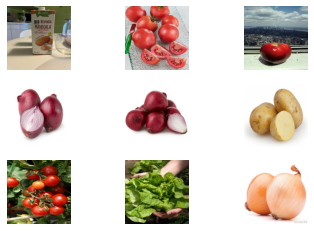

In [8]:
for images, labels in train_ds.take(1):
    print(labels)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

The next step is to understand more about data caching:
- Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache. See https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache
- Dataset.prefetch overlaps data preprocessing and model execution while training.
Now, we must combine both of these steps to 

In [9]:
# Cache the data

First, note the difference between normalization and scaling:

> Scaling just changes the range of your data. Normalization is a more radical transformation. The point of normalization is to change your observations so that they can be described as a normal distribution.

Next step is normalizing the data. 

In [10]:
normalization_layer = layers.BatchNormalization() # Will be used as part of the model definition
# another way to normalize:
# layers.Rescaling(1./255, (img_height, img_width, 3))

In [11]:
#Other useful layers
maxPool = layers.MaxPooling2D()

Now, writing the model. I will test two types of models: one with a pretrained base and another with a smaller custom base

In [12]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(6)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
2/2 [==============================] - 5s 2s/step - loss: 2.3920 - accuracy: 0.2692 - val_loss: 3.1550 - val_accuracy: 0.0769
Epoch 2/10
2/2 [==============================] - 4s 1s/step - loss: 1.8415 - accuracy: 0.3462 - val_loss: 1.5416 - val_accuracy: 0.3846
Epoch 3/10
2/2 [==============================] - 4s 1s/step - loss: 1.2029 - accuracy: 0.5577 - val_loss: 1.6543 - val_accuracy: 0.3846
Epoch 4/10
2/2 [==============================] - 4s 1s/step - loss: 1.0329 - accuracy: 0.6154 - val_loss: 1.7007 - val_accuracy: 0.4615
Epoch 5/10
2/2 [==============================] - 4s 1s/step - loss: 0.8213 - accuracy: 0.7308 - val_loss: 1.7116 - val_accuracy: 0.2308
Epoch 6/10
2/2 [==============================] - 4s 1s/step - loss: 0.6530 - accuracy: 0.8462 - val_loss: 1.7878 - val_accuracy: 0.3077
Epoch 7/10
2/2 [==============================] - 4s 1s/step - loss: 0.4747 - accuracy: 0.9038 - val_loss: 2.1487 - val_accuracy: 0.4615
Epoch 8/10
2/2 [=========================

In [13]:
pretrained_base = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(img_height,img_width, 3),
    pooling="MAX"
)
pretrained_base.trainable = False

In [14]:
model_pretrainedBase = keras.Sequential([
    #Data augmentation
    layers.RandomContrast(factor=0.75),
    layers.RandomRotation(factor=0.10),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.1),
    
    #Base
    pretrained_base,
    
    #Head
    layers.Flatten(),
    layers.Dense(6, activation = "relu"),
    layers.Dense(6)
])

In [15]:
model_smallerBase = keras.Sequential([
    #Data augmentation
    layers.RandomContrast(factor=0.75),
    layers.RandomRotation(factor=0.10),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.1),
    
    #First block
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    
    #Second block
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    
    #Third block
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    
    #Head
    layers.InputLayer(input_shape=[img_height,img_width, 3]),
    layers.Flatten(),
    layers.Dense(6, activation = "relu"),
    layers.Dense(6)
    
])

In [16]:
model_smallerBase.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_pretrainedBase.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
history = model_pretrainedBase.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
)

Epoch 1/10
2/2 [==============================] - 28s 13s/step - loss: 8.7976 - accuracy: 0.1923 - val_loss: 1.7930 - val_accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 27s 13s/step - loss: 1.6429 - accuracy: 0.2500 - val_loss: 1.7940 - val_accuracy: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 27s 13s/step - loss: 1.5237 - accuracy: 0.2692 - val_loss: 1.7948 - val_accuracy: 0.1538
Epoch 4/10
2/2 [==============================] - 27s 13s/step - loss: 1.4643 - accuracy: 0.3846 - val_loss: 1.7953 - val_accuracy: 0.1538
Epoch 5/10
2/2 [==============================] - 26s 13s/step - loss: 1.3811 - accuracy: 0.3846 - val_loss: 1.7958 - val_accuracy: 0.1538
Epoch 6/10
2/2 [==============================] - 28s 15s/step - loss: 1.6374 - accuracy: 0.3846 - val_loss: 1.7961 - val_accuracy: 0.1538
Epoch 7/10
2/2 [==============================] - 126s 113s/step - loss: 1.3129 - accuracy: 0.4231 - val_loss: 1.7964 - val_accuracy: 0.1538
Epoch 8/10
2/2 [=

In [18]:
history = model_smallerBase.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
)

Epoch 1/10
2/2 [==============================] - 8s 2s/step - loss: 6.4504 - accuracy: 0.1154 - val_loss: 1.7928 - val_accuracy: 0.1538
Epoch 2/10
2/2 [==============================] - 6s 2s/step - loss: 1.7916 - accuracy: 0.1346 - val_loss: 1.7937 - val_accuracy: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 6s 2s/step - loss: 1.7914 - accuracy: 0.2115 - val_loss: 1.7947 - val_accuracy: 0.0000e+00
Epoch 4/10
2/2 [==============================] - 5s 2s/step - loss: 1.7911 - accuracy: 0.2115 - val_loss: 1.7958 - val_accuracy: 0.0000e+00
Epoch 5/10
2/2 [==============================] - 5s 2s/step - loss: 1.7909 - accuracy: 0.2115 - val_loss: 1.7968 - val_accuracy: 0.0000e+00
Epoch 6/10
2/2 [==============================] - 5s 2s/step - loss: 1.7907 - accuracy: 0.2115 - val_loss: 1.7979 - val_accuracy: 0.0000e+00
Epoch 7/10
2/2 [==============================] - 6s 2s/step - loss: 1.7903 - accuracy: 0.2115 - val_loss: 1.7989 - val_accuracy: 0.0000e+00
Epoch 8/10
2/2 [=